In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial.distance import pdist, squareform


In [46]:
file_path = "/Users/owlxshri/desktop/coral reef/mlpr-project/statisticalinf/finaldata_onehotafterdropreefname.csv"
df = pd.read_csv(file_path)

In [47]:
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())
print(df.shape)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            1200 non-null   int64  
 1   Month                           1200 non-null   int64  
 2   SST_MIN                         1200 non-null   float64
 3   SST_MAX                         1200 non-null   float64
 4   SST@90th_HS                     1200 non-null   float64
 5   SSTA@90th_HS                    1200 non-null   float64
 6   DHW_from_90th_HS>1              1200 non-null   float64
 7   Salinity                        1200 non-null   float64
 8   pH_total                        1200 non-null   float64
 9   fCO2                            1200 non-null   float64
 10  IOD                             1200 non-null   float64
 11  ENSO                            1200 non-null   float64
 12  Bleaching           

In [18]:
missing_threshold = 0.3  # Drop columns with more than 30% missing values
df = df.dropna(axis=1, thresh=int(missing_threshold * len(df)))
print("Remaining columns after dropping those with >30% missing values:", df.columns)
df.fillna(df.median(numeric_only=True), inplace=True)  # Fill remaining missing values with median

Remaining columns after dropping those with >30% missing values: Index(['Year', 'Month', 'Reef Name', 'SST_MIN', 'SST_MAX', 'SST@90th_HS',
       'SSTA@90th_HS', 'DHW_from_90th_HS>1', 'Salinity', 'pH_total', 'pCO2',
       'fCO2', 'IOD', 'ENSO', 'Bleaching', 'Genera'],
      dtype='object')


In [19]:
print("\nNumber of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()


Number of duplicate rows: 0


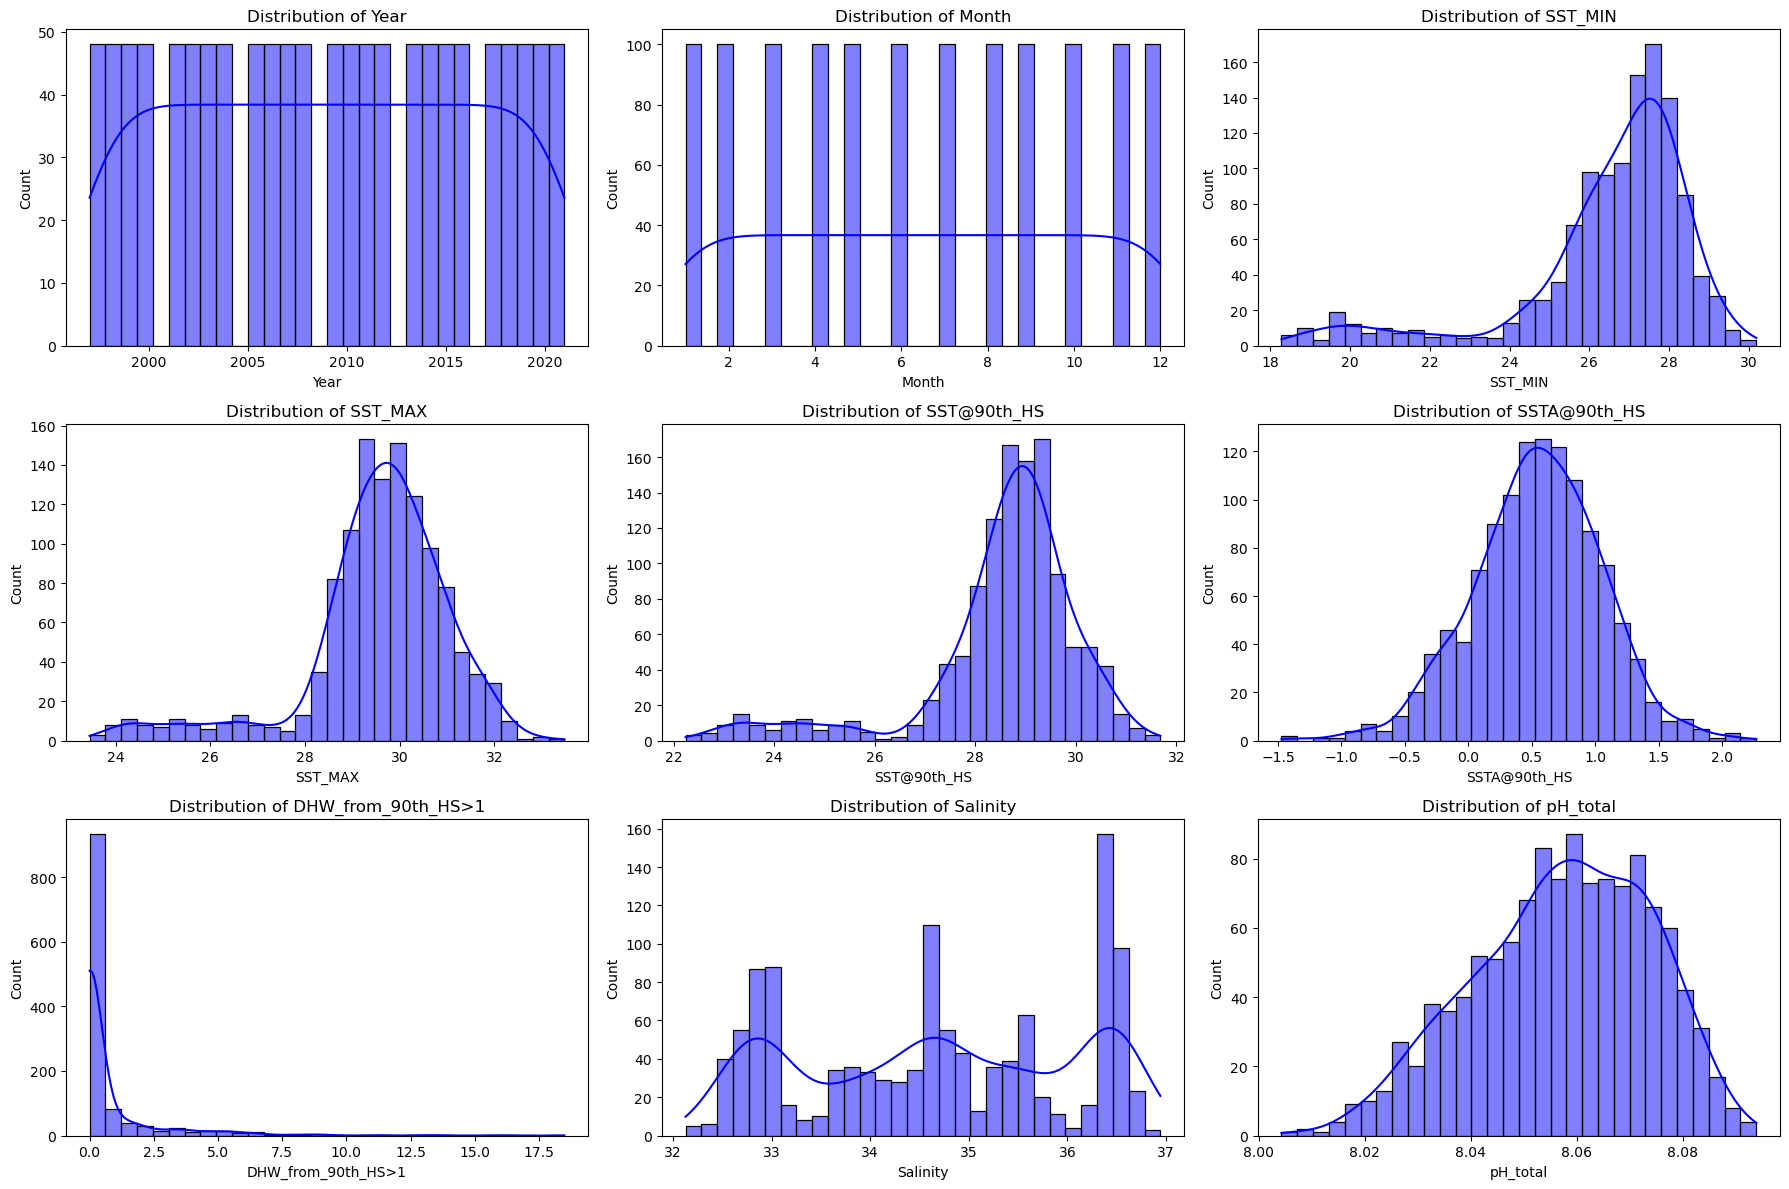

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
columns_to_plot = df.select_dtypes(include=[np.number]).columns[:9]
for col, ax in zip(columns_to_plot, axes.flatten()):
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="blue")
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

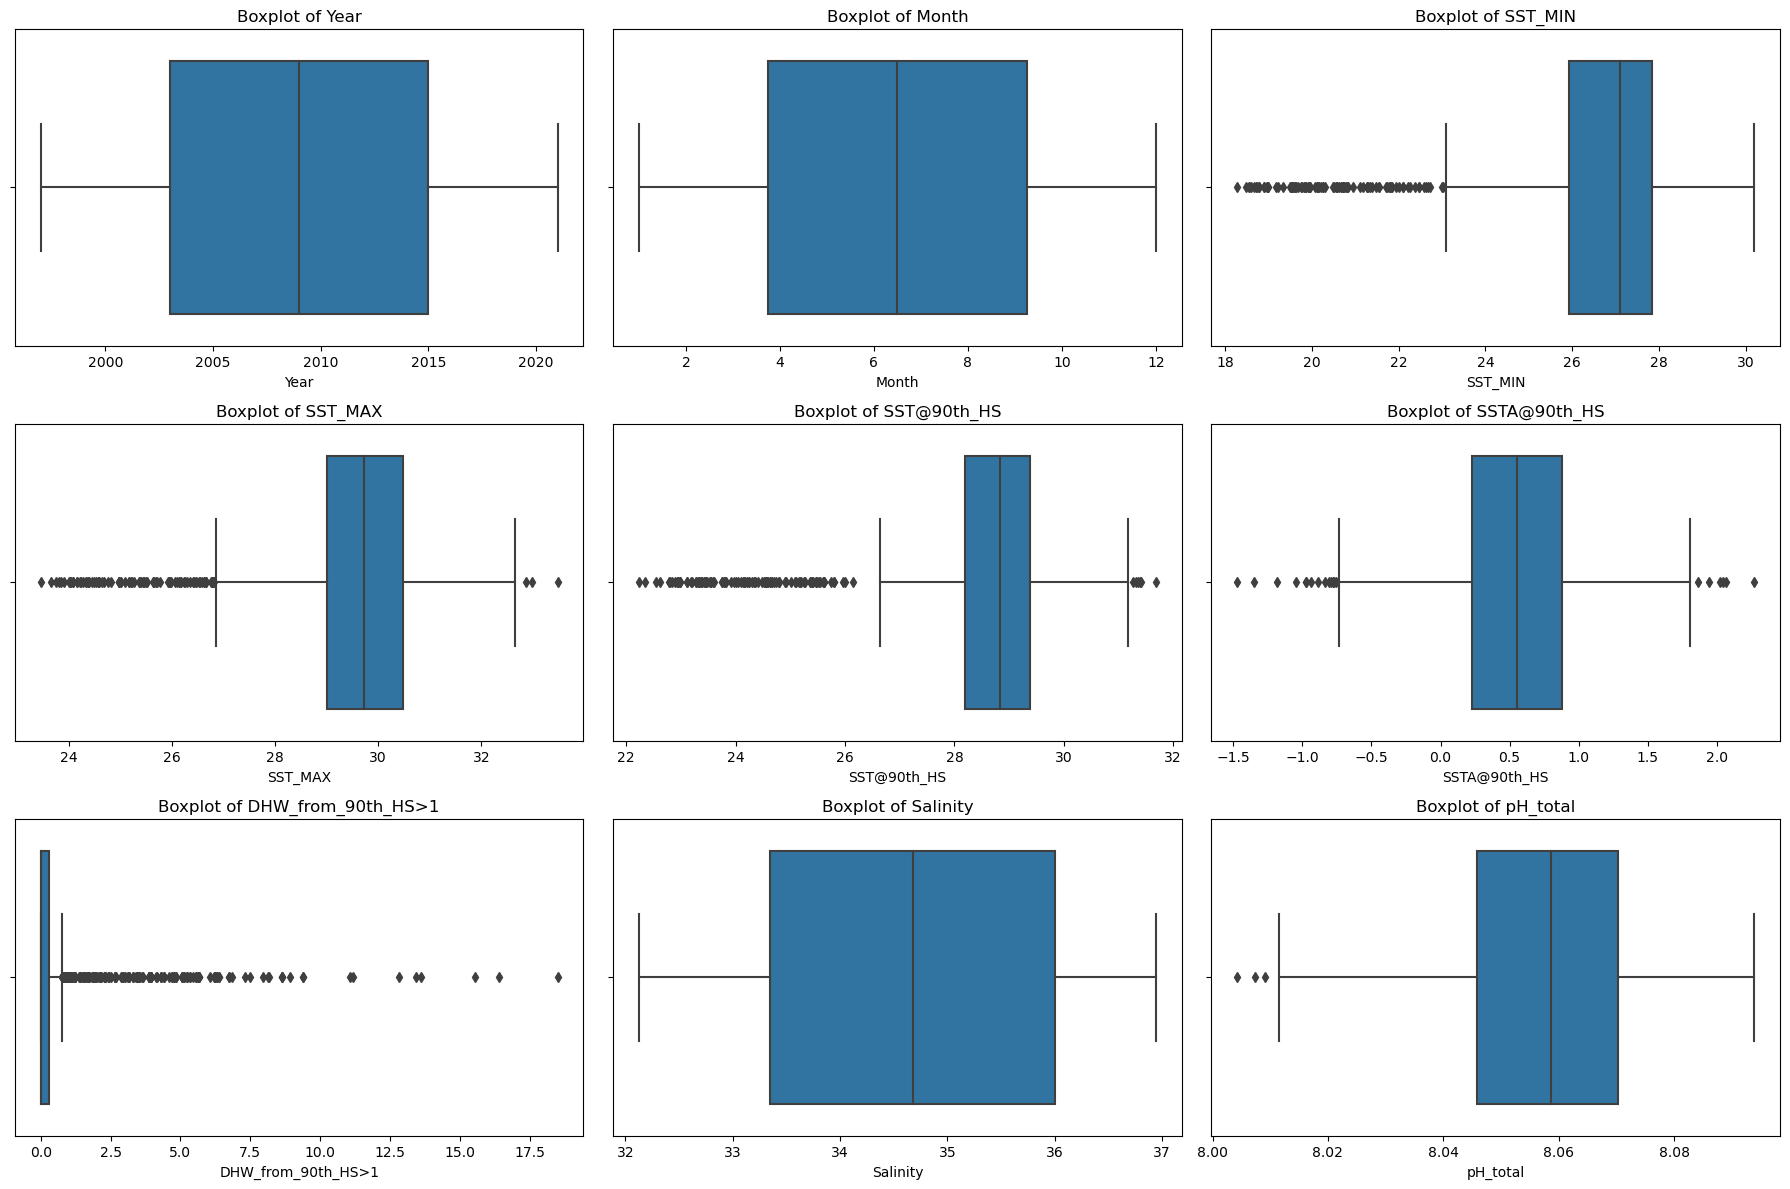

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for col, ax in zip(columns_to_plot, axes.flatten()):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

/var/folders/rh/12qqnf0d5871pn0c7924tqwc0000gn/T/ipykernel_86515/1985205203.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)


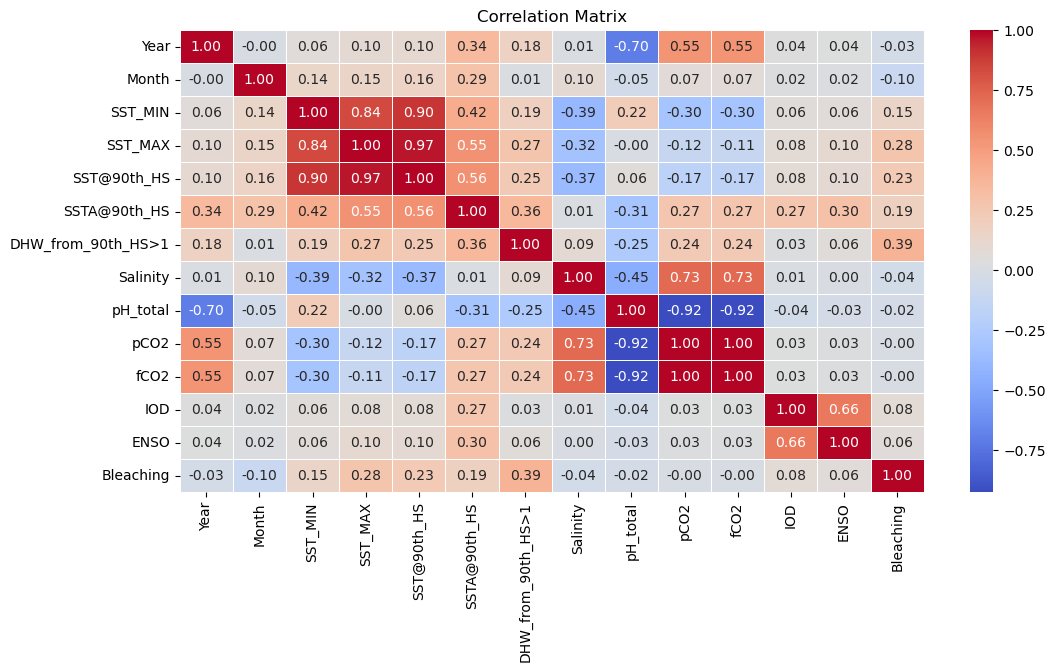

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

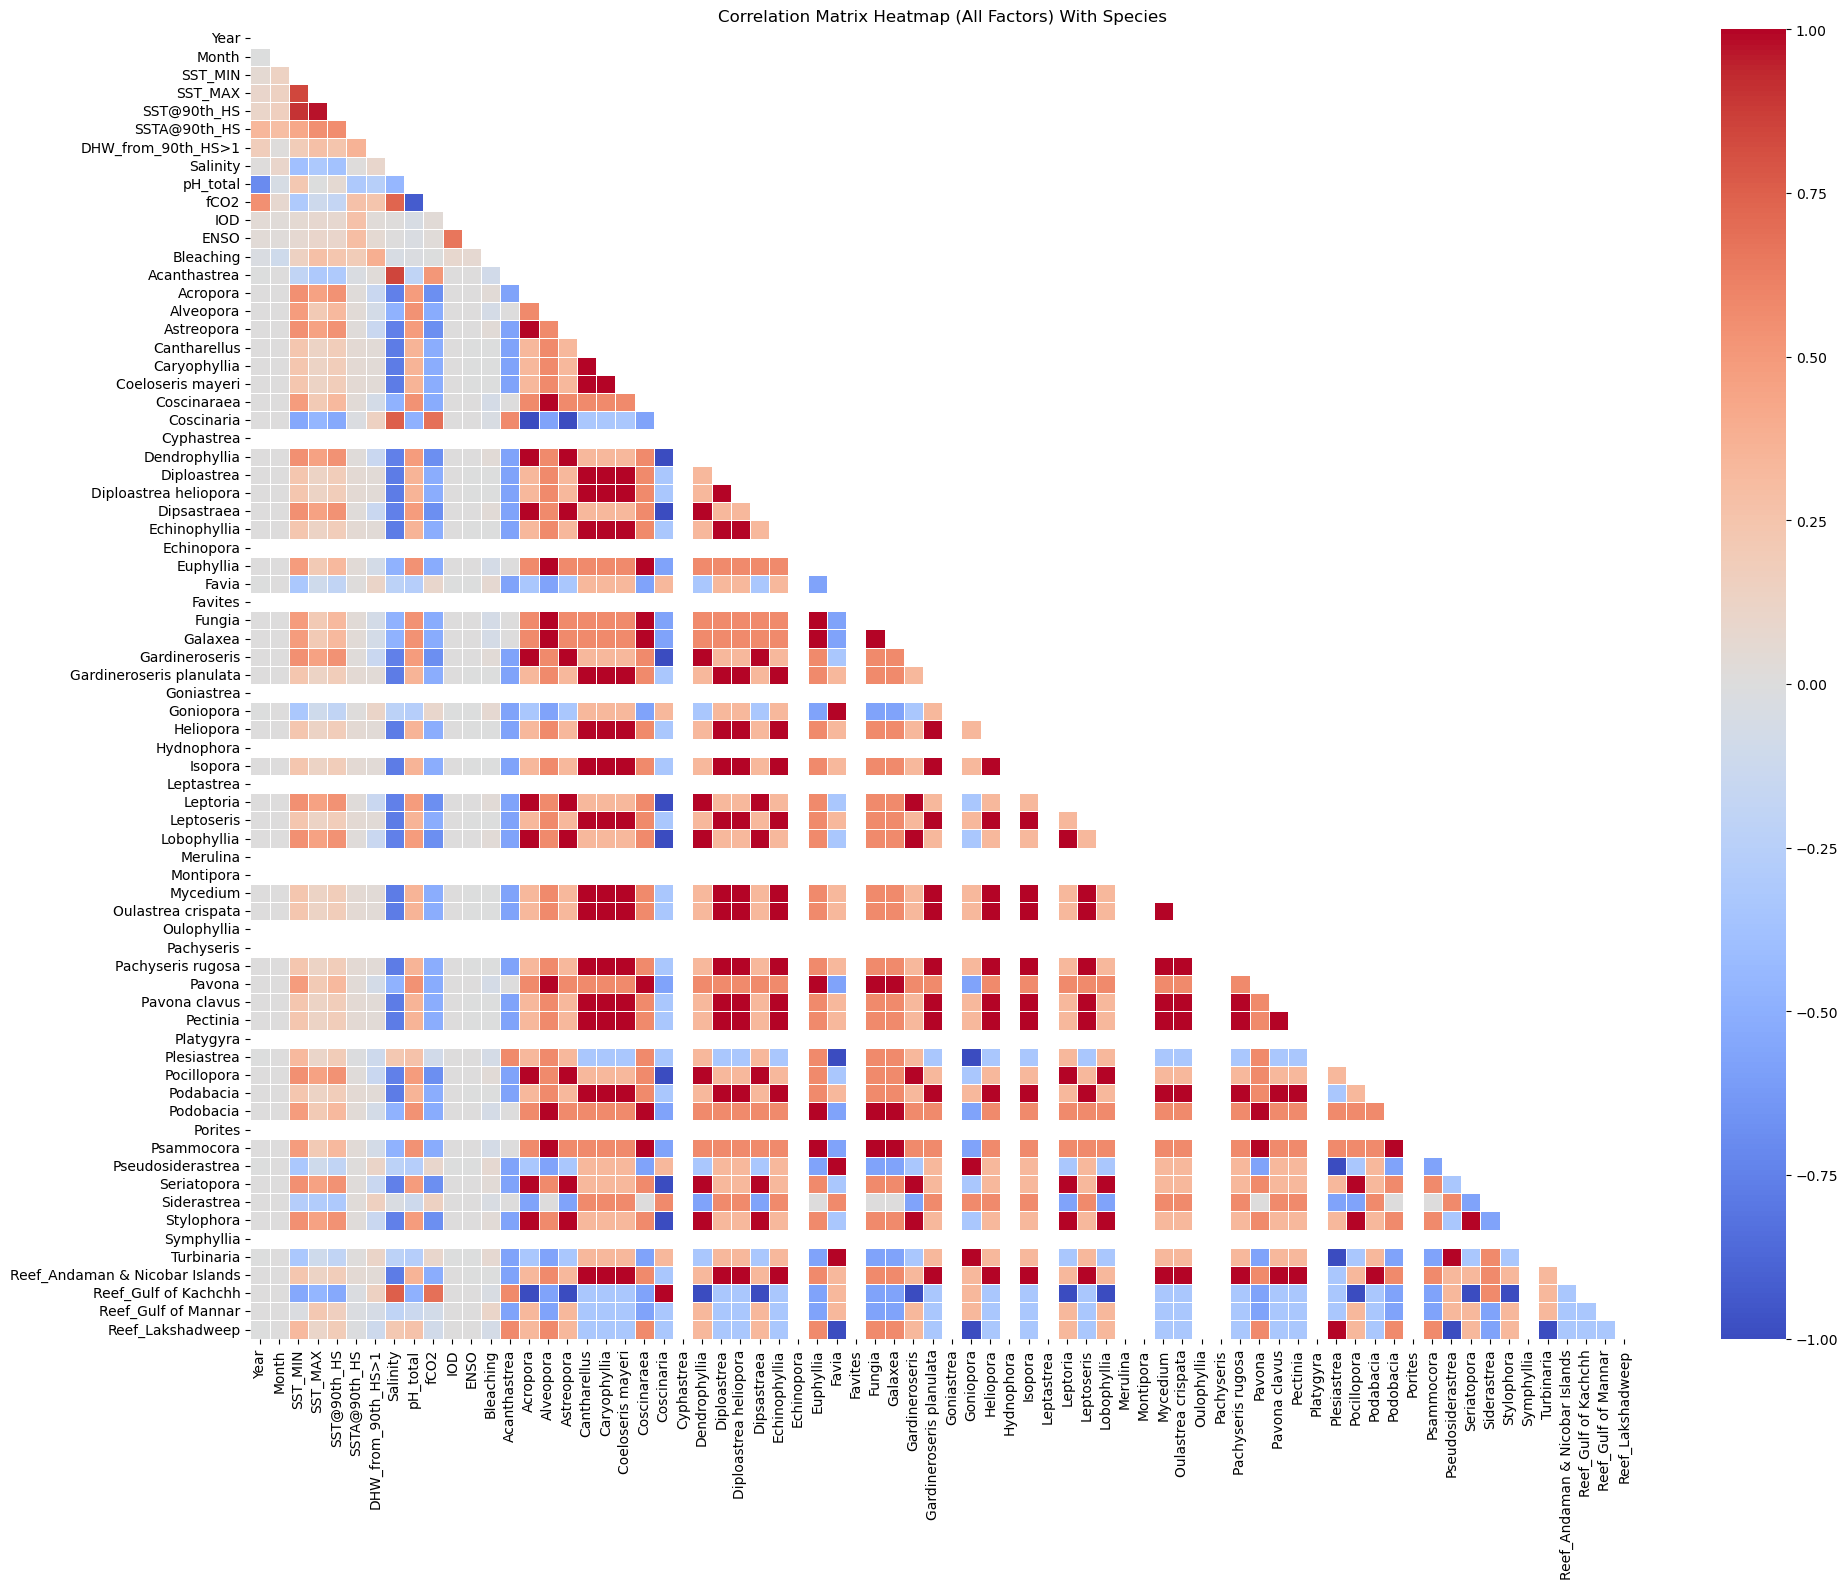

All correlations with Bleaching:
Bleaching             1.000000
DHW_from_90th_HS>1    0.387744
SST_MAX               0.276471
SST@90th_HS           0.234477
SSTA@90th_HS          0.187816
                        ...   
Oulophyllia                NaN
Pachyseris                 NaN
Platygyra                  NaN
Porites                    NaN
Symphyllia                 NaN
Name: Bleaching, Length: 72, dtype: float64


In [3]:
file_path = "/Users/owlxshri/desktop/coral reef/mlpr-project/statisticalinf/finaldata_onehotafterdrop.csv"
df = pd.read_csv(file_path)

df['Year'] = pd.to_numeric(df['Year'])
df['Month'] = pd.to_numeric(df['Month'])


reef_dummies = pd.get_dummies(df['Reef Name'], prefix='Reef')
df = pd.concat([df, reef_dummies], axis=1)


df_numeric = df.drop(columns=['Reef Name'])


corr_matrix = df_numeric.corr()


plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,  
    linewidths=0.5,
    mask=mask,    
    vmin=-1,
    vmax=1
)

plt.title("Correlation Matrix Heatmap (All Factors) With Species")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


bleaching_correlations = corr_matrix['Bleaching'].sort_values(ascending=False)
print("All correlations with Bleaching:")
print(bleaching_correlations)  


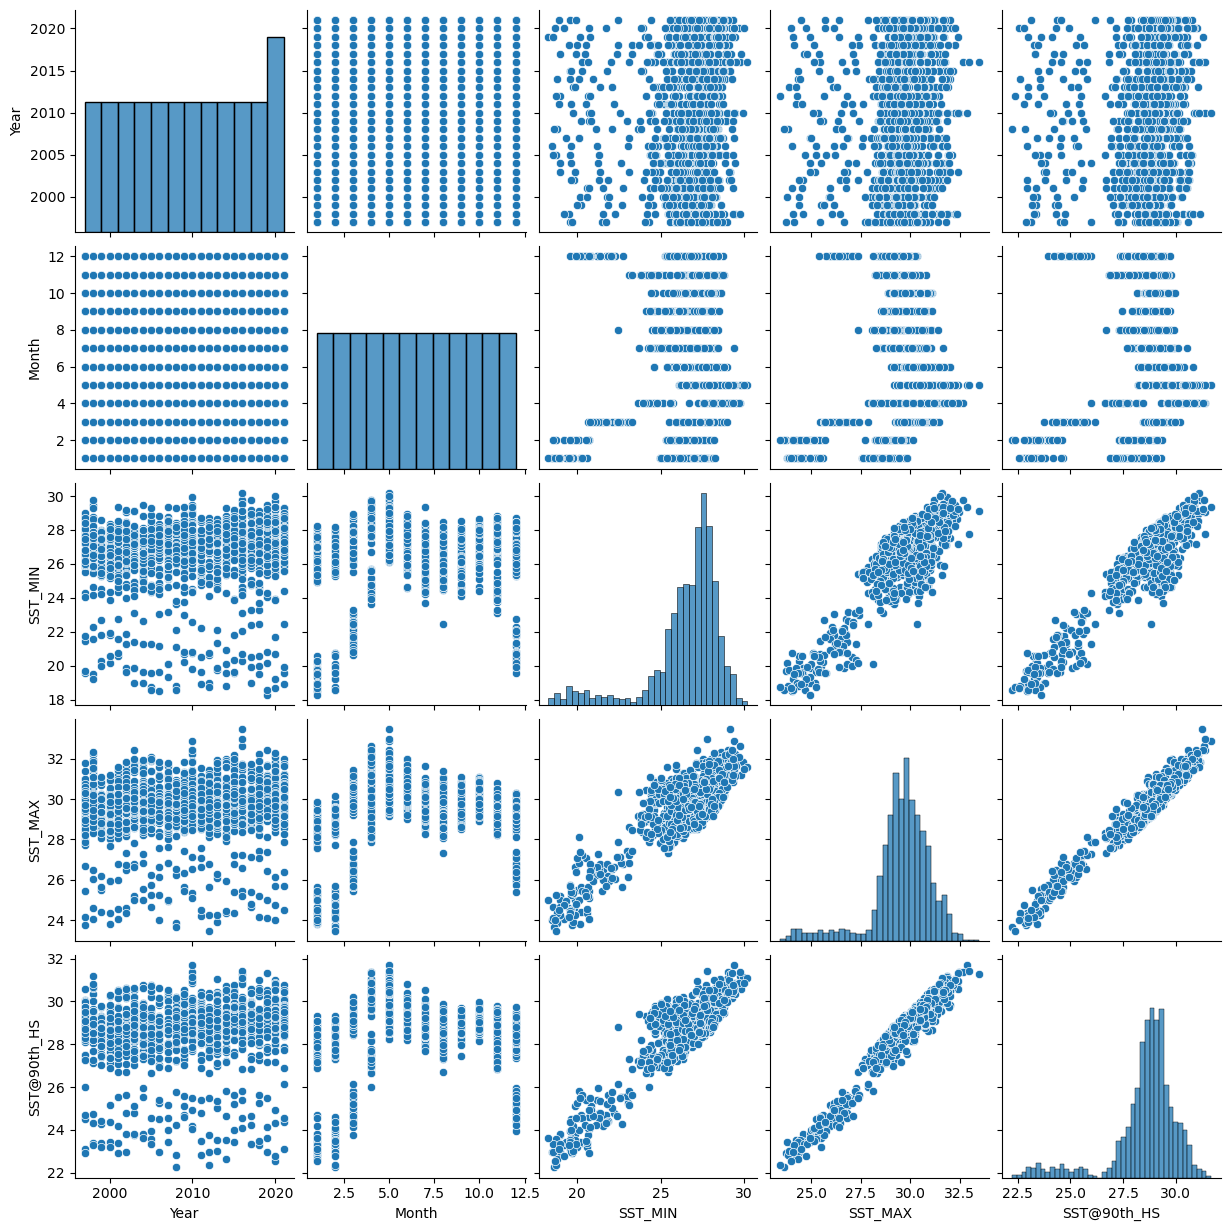

In [23]:
sns.pairplot(df[columns_to_plot[:5]])  # Plot first 5 numerical columns
plt.show()

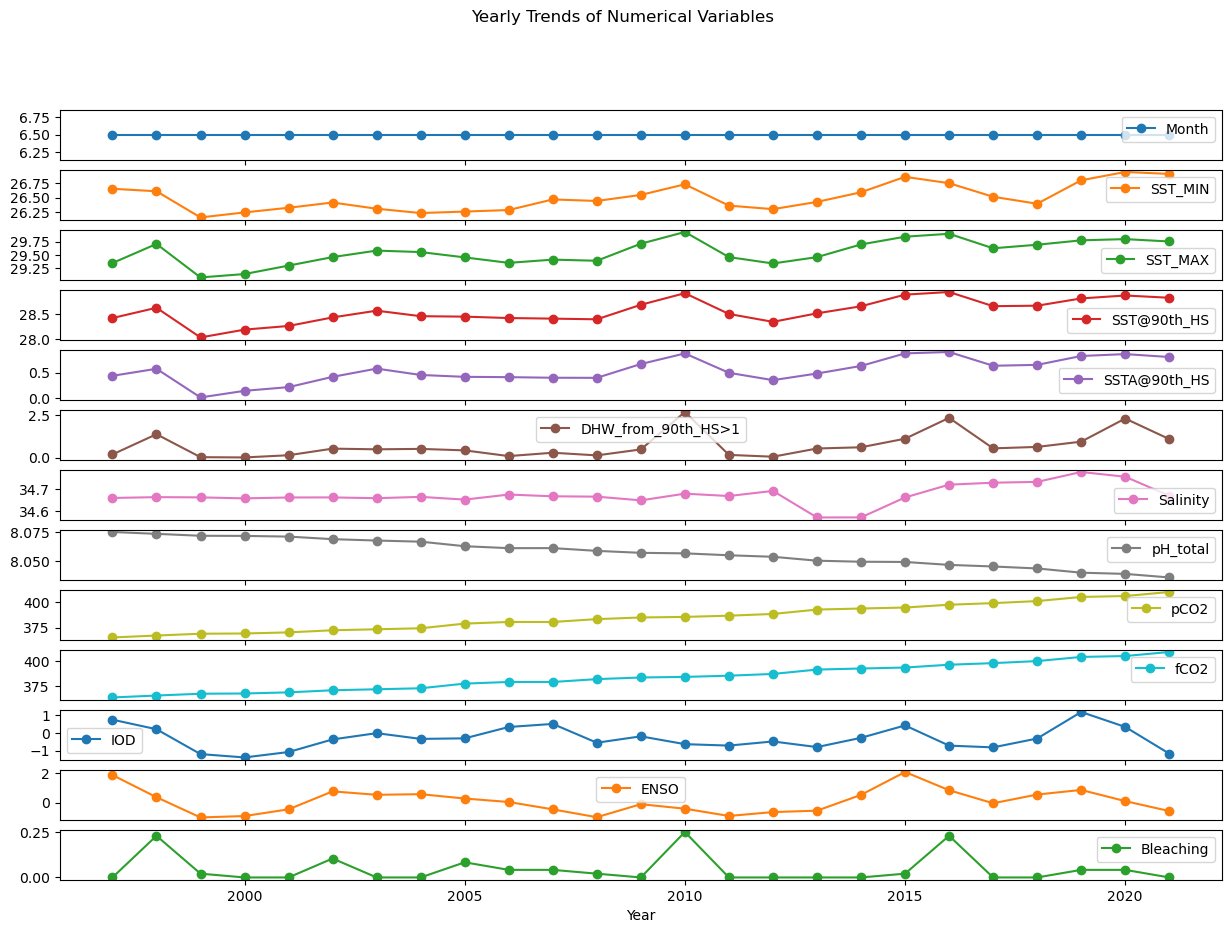

In [24]:
if 'Year' in df.columns:
    df_yearly = df.groupby("Year").mean(numeric_only=True)
    df_yearly.plot(subplots=True, figsize=(15, 10), marker="o")
    plt.suptitle("Yearly Trends of Numerical Variables")
    plt.show()

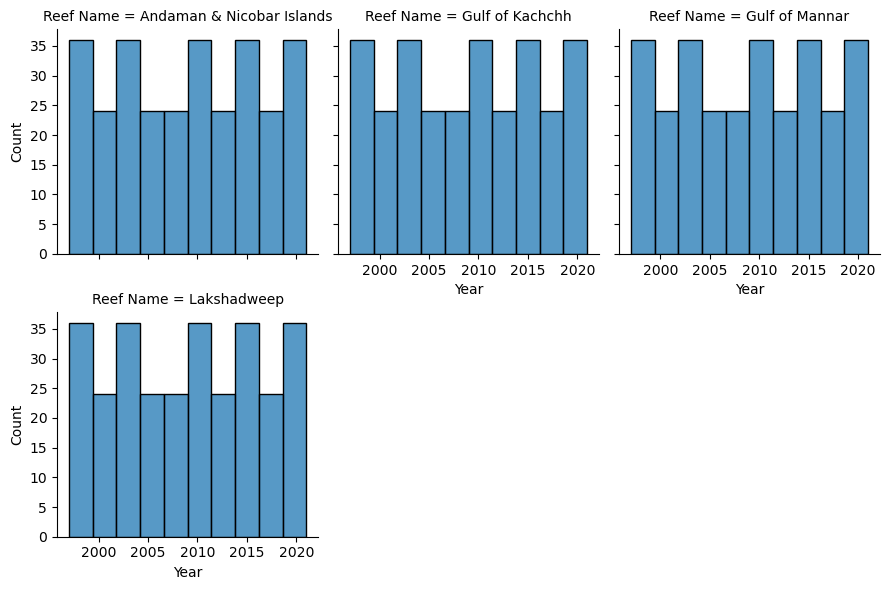

In [25]:
cat_columns = df.select_dtypes(include=['object']).columns
if len(cat_columns) > 0:
    grid = sns.FacetGrid(df, col=cat_columns[0], col_wrap=3)
    grid.map(sns.histplot, columns_to_plot[0])
    plt.show()

In [26]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.select_dtypes(include=[np.number])), columns=df.select_dtypes(include=[np.number]).columns)
print("\nStandardized Numerical Data Preview:")
print(df_scaled.head())


Standardized Numerical Data Preview:
       Year     Month   SST_MIN   SST_MAX  SST@90th_HS  SSTA@90th_HS  \
0 -1.664101 -1.593255 -0.302482 -1.022485    -0.660337     -1.304966   
1 -1.664101 -1.593255 -3.189058 -3.490507    -3.435800     -2.025873   
2 -1.664101 -1.593255 -0.320839 -1.093741    -0.814915     -1.382868   
3 -1.664101 -1.593255  0.362944 -0.536654    -0.189875     -0.783675   
4 -1.664101 -1.303572 -0.440157 -1.177951    -0.772811     -1.994525   

   DHW_from_90th_HS>1  Salinity  pH_total      pCO2      fCO2       IOD  \
0            -0.38295 -1.444566  2.021740 -1.927621 -1.928222 -0.521669   
1            -0.38295  1.273395  0.286051  0.253430  0.251024 -0.521669   
2            -0.38295 -0.799537  1.234660 -1.714408 -1.715244 -0.521669   
3            -0.38295  0.223823  1.497416 -1.020743 -1.020768 -0.521669   
4            -0.38295 -1.386382  2.207285 -1.943935 -1.944449 -0.807859   

       ENSO  Bleaching  
0  0.104864  -0.217072  
1  0.104864  -0.217072  
2  

In [27]:
if 'Latitude' in df.columns and 'Longitude' in df.columns:
    plt.figure(figsize=(12, 8))
    sc = plt.scatter(df["Longitude"], df["Latitude"], c=df.get("pCO2", pd.Series()), cmap="coolwarm", alpha=0.7, edgecolors="k")
    plt.colorbar(sc, label="pCO₂ Levels")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Geospatial Distribution of pCO₂")
    plt.show()

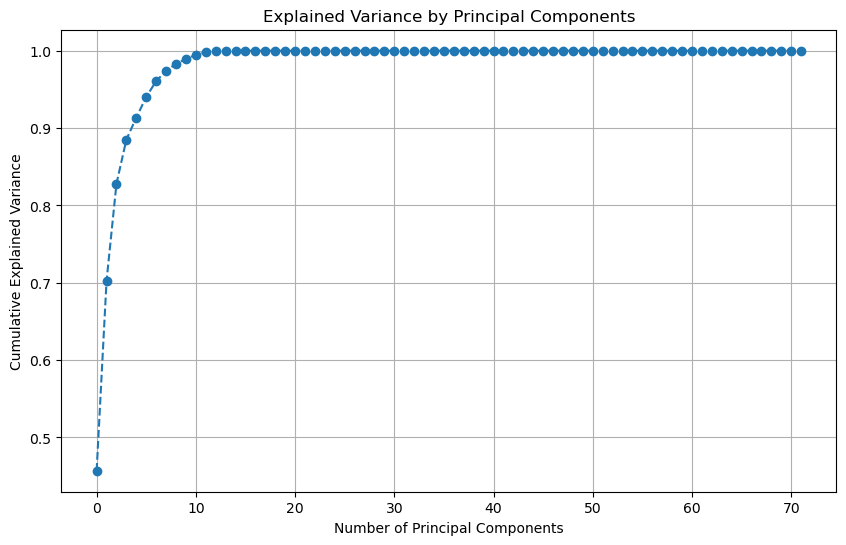

Number of components to retain 95% variance: 7
PCA-transformed file saved to: /Users/owlxshri/desktop/coral reef/mlpr-project/statisticalinf/pcadata.csv


In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

file_path = "/Users/owlxshri/desktop/coral reef/mlpr-project/statisticalinf/finaldata_onehotafterdropreefname.csv"
df = pd.read_csv(file_path)


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


pca = PCA()
principal_components = pca.fit_transform(df_scaled)


explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid()
plt.show()


num_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {num_components}")


pca = PCA(n_components=num_components)
df_pca = pca.fit_transform(df_scaled)


df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(num_components)])


output_path = "/Users/owlxshri/desktop/coral reef/mlpr-project/statisticalinf/pcadata.csv"
df_pca.to_csv(output_path, index=False)
print(f"PCA-transformed file saved to: {output_path}")


In [1]:
# Mean bleaching by year and by reef
print(df.groupby('Year')['Bleaching'].mean())
for reef in reef_cols:
    print(f"Mean bleaching for {reef}:")
    print(df.groupby(reef)['Bleaching'].mean())

NameError: name 'df' is not defined